In [1]:
import os
os.chdir('/Users/younghun/Desktop/inflearn강의자료/머신러닝강의/PerfectGuid수정ver01/1장/titanic')

# Accuracy(정확도)

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

# 일부러 이상한 분류 알고리즘 만들기 실습임
# class 상속해보기        # 상속받는 Class를 입력
class MyDummyClassifier(BaseEstimator):
    # fit에서는 아무것도 하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict 메소드에서는 단순히 성별 feature가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros( (X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

# Confusion Matrix

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행. 
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test , mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [5]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix출력
confusion_matrix(y_test , mypredictions)

array([[92, 18],
       [20, 49]])

# Precision, Recall

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("정밀도 :", precision_score(y_test, mypredictions))
print("재현율 :", recall_score(y_test, mypredictions))

정밀도 : 0.7313432835820896
재현율 : 0.7101449275362319


In [7]:
# 오차행렬(confusion matrix), 정밀도, 재현율 한꺼번에 계산하는 함수 생성
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬 :\n', confusion)
    print(f"정확도 :{accuracy:.4f}', 정밀도 :{precision:.4f}, 재현율 :{recall:.4f}")

In [8]:
get_clf_eval(y_test, mypredictions)

오차행렬 :
 [[92 18]
 [20 49]]
정확도 :0.7877', 정밀도 :0.7313, 재현율 :0.7101


## precision-recall Trade-off

In [9]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, \
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
# get_clf_eval함수는 Confusion Matrix, Accuracy, Precision, Recall을 한 번에 출력하기 위해 정의한 함수.
get_clf_eval(y_test , pred)

오차행렬 :
 [[104  14]
 [ 13  48]]
정확도 :0.8492', 정밀도 :0.7742, 재현율 :0.7869


In [10]:
# 각 label로 될 확률을 2d array로 반환해줌
pred_proba = lr_clf.predict_proba(X_test)
# 예측 label 반환
pred = lr_clf.predict(X_test)

print('pred_proba 결과 shape:', pred_proba.shape)
print('pred_proba 결과 array앞에서 앞 3개행들만 추출: \n', pred_proba[:3])

# 예측확률과 예측값을 붙이기
# 예측값을 2d array로 만들어주고 붙여야함 - np.concatenate 사용
pred_proba_result = np.concatenate([pred_proba,
                                   pred.reshape(-1,1)],
                                  axis=1)
print("두 개를 붙인 결과 앞의 3개값:\n",pred_proba_result[:3])

pred_proba 결과 shape: (179, 2)
pred_proba 결과 array앞에서 앞 3개행들만 추출: 
 [[0.46200919 0.53799081]
 [0.87869718 0.12130282]
 [0.8771684  0.1228316 ]]
두 개를 붙인 결과 앞의 3개값:
 [[0.46200919 0.53799081 1.        ]
 [0.87869718 0.12130282 0.        ]
 [0.8771684  0.1228316  0.        ]]


In [11]:
# Binarizer를 활용해 임계값을 설정해주고 그 값에 따라 분류하도록 하기
# 임계값을 0.5로 설정했을 때
from sklearn.preprocessing import Binarizer
custom_threshold = 0.5

# predict_proba 반환값에 두번째 칼럼인 Positive(1) 클래스들만 추출후 2d array로 변환
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
# 0.5로 설정한 임계치로 Positive 클래스 칼럼에 적용
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

# 그냥 모델링했을 때와 결과 똑같음(위위셀과)
get_clf_eval(y_test, custom_predict)

오차행렬 :
 [[104  14]
 [ 13  48]]
정확도 :0.8492', 정밀도 :0.7742, 재현율 :0.7869


In [12]:
# 임계값을 0.4로 설정했을 때
from sklearn.preprocessing import Binarizer
custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)
custom_predict = Binarizer(threshold=custom_threshold).fit_transform(pred_proba_1)

# 결과값이 달라짐
get_clf_eval(y_test, custom_predict)

오차행렬 :
 [[98 20]
 [10 51]]
정확도 :0.8324', 정밀도 :0.7183, 재현율 :0.8361


In [22]:
print(y_test.shape, custom_predict.shape)

(179,) (179, 1)


In [13]:
# precision_recall_curve를 이용해 임곗값에 따른 정밀도-재현율 값 추출
from sklearn.metrics import precision_recall_curve

# label이 Positive(1)일 때의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# precision_recall_curve는 실제값과 Positive예측확률을 인자로 넣고
# 정밀도, 재현율, 임곗값 3가지를 반환받음
precision, recalls, thresholds = precision_recall_curve(y_test,
                                                        pred_proba_class1)
print("임곗값 shape", thresholds.shape)
print("정밀도 shape", precision.shape)
print("재현율 shape", recalls.shape)

#반환된 임곗값 배열 row가 143건이므로 샘플로 10개 추출하되, 14번의 step으로 추출
thr_idx = np.arange(0, thresholds.shape[0], 14)
print("추출한 임곗값 인덱스", thr_idx)
print("샘플링한 10개 임곗값", np.round(thresholds[thr_idx], 2))

#위에 설정한 임곗값 인덱스에 매핑되는 정밀도와 재현율 출력
print("정밀도:", np.round(precision[thr_idx], 3))
print("재현율:", np.round(recalls[thr_idx], 3))

임곗값 shape (143,)
정밀도 shape (144,)
재현율 shape (144,)
추출한 임곗값 인덱스 [  0  14  28  42  56  70  84  98 112 126 140]
샘플링한 10개 임곗값 [0.1  0.12 0.13 0.17 0.25 0.36 0.51 0.63 0.75 0.88 0.95]
정밀도: [0.389 0.437 0.458 0.524 0.618 0.707 0.787 0.913 0.938 0.944 1.   ]
재현율: [1.    0.967 0.902 0.902 0.902 0.869 0.787 0.689 0.492 0.279 0.066]


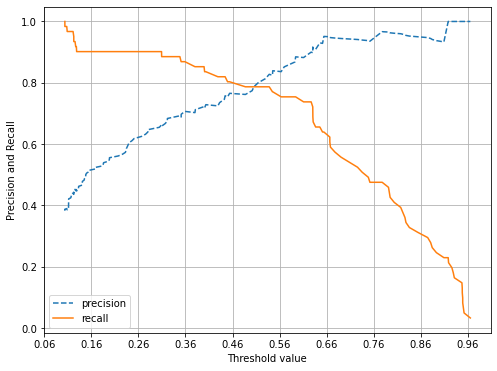

In [14]:
# 임곗값의 변경에 따른 정밀도-재현율 변화곡선 그리기
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_prob_c1):
    precision, recall, thresholds = precision_recall_curve(y_test, pred_prob_c1)
    
    # X축을 thresholds 값으로 
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary],
            linestyle='--', label='precision')
    plt.plot(thresholds, recall[0:threshold_boundary],
            label='recall')
    
    # thresholds값들을 0.1단위로 바꾸고 소수점 둘째자리 이후 없애기
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

# F1 Score

In [15]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f" F1-score : {f1:.2f}")

 F1-score : 0.78


# ROC Curve and AUC

In [16]:
from sklearn.metrics import roc_curve

# label이 Positive(1)일때의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# roc_curve함수는 실제값, 예측확률값(1일때)를 인자로 주고 3개의 값들을 반환받는다.
# fpr : Fall-out
# tpr : Recall
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_idx = np.arange(0, thresholds.shape[0], 5)
print("임곗값 인덱스", thr_idx)
print("샘플용 10개 임곗값", np.round(thresholds[thr_idx], 2))

print("임곗값에 따른 FPR", np.round(fprs[thr_idx], 3))
print("임곗값에 따른 TPR", np.round(tprs[thr_idx], 3))

임곗값 인덱스 [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개 임곗값 [1.97 0.75 0.63 0.59 0.49 0.4  0.35 0.23 0.13 0.12 0.11]
임곗값에 따른 FPR [0.    0.017 0.034 0.051 0.127 0.161 0.203 0.331 0.585 0.636 0.797]
임곗값에 따른 TPR [0.    0.475 0.689 0.754 0.787 0.836 0.869 0.902 0.918 0.967 0.967]


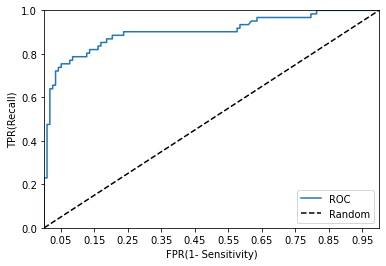

In [17]:
# ROC curve 그래프 그리기
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC Curve를 plot으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # Random한 가운데선(0.5)을 직선으로 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1- Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [18]:
# AUC score 출력
# roc_auc_score함수 사용
from sklearn.metrics import roc_auc_score

# roc_auc_score(y_test, predict_proba가 반환한 객체)를 인자로 한다.
pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f"ROC score : {roc_score:.3f}")

ROC score : 0.902
